# Генеративно-состязательные модели

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/GAN_deepfake_white_girl.jpg/480px-GAN_deepfake_white_girl.jpg "")

В этом проекте мы обучим нейросеть генерировать лица людей и посмотрим на то, как можно оценивать качество генерации. В качестве обучающей выборки возьмём датасет [Flickr-Faces](https://github.com/NVlabs/ffhq-dataset).

Мы будем работать с [генеративно-состязательной сетью](https://ru.wikipedia.org/wiki/%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%BE-%D1%81%D0%BE%D1%81%D1%82%D1%8F%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C), которая состоит из двух отдельных нейросетей: генератора и дискриминатора. Генератор создаёт изображения (в нашем случае - фотографии людей), а дискриминатор пытается отличить их от правильных (настоящих) фотографий. 

Фотография, приведённая над данным текстом, на самом деле была сгенерирована нейросетью. У нас врядли получится достичь такой же фотореалистичности, но в данной работе будут продемонстрированы основные подходы и некоторые трюки, применяемые при обучении генеративно-состязательных нейросетей.

In [ ]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam

from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import save_image
from torchvision.utils import make_grid

from tqdm.notebook import tqdm, trange

import pandas as pd
import numpy as np

import pytorch_lightning as pl

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (18, 6)})

## Подготовка данных

Наши изображения уже загружены и имеют размер 128 на 128 пикселей. Создадим `DataModule`, чтобы нейросети было удобнее работать с данными. Для генеративно-состязательных сетей нам нужна только обучающая выборка, валиадационый и тестовый датасеты создавать не нужно.

In [ ]:
BATCH_SIZE = 16
LATENT_SIZE = 128

In [ ]:
class FacesDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = BATCH_SIZE):
        super().__init__()
        self.batch_size = batch_size
        self.transforms = tt.Compose([
            tt.Resize(128),
            tt.CenterCrop(128),
            tt.ToTensor(),
            tt.Normalize((0.5, 0.5, 0.5), 
                         (0.5, 0.5, 0.5))
        ])
        
    def prepare_data(self):
        if not os.path.exists('./data/'):
            os.system('mkdir ./data/')
            os.system('cp ./thumbnails128x128.zip ./data/')
            os.system('unzip -ouq ./data/thumbnails128x128.zip -d ./data/')

    def setup(self, stage: str):
        self.train_dataset = train_dataset = ImageFolder(root='./data/', 
                                                         transform=self.transforms)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, 
                          batch_size=self.batch_size, 
                          shuffle=True, 
                          num_workers=12, 
                          pin_memory=True)


In [ ]:
data_module = FacesDataModule(batch_size=BATCH_SIZE)

Модуль данных готов, можно приступать к созданию моделей.

## Построение и обучение модели

Сконструируем генератор и дискриминатор. Дискриминатор будет принимать на вход изображения и выдавать вероятность того, что изображение настоящее. Генератор будет принимать на вход тензор шумов и генерировать изображения.

In [ ]:
class FacesDiscriminator(pl.LightningModule):
    def __init__(self):
        super().__init__()        
       
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, 
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, 
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, 
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, 
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1024, kernel_size=4, 
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(1024, 1, kernel_size=4, 
                      stride=1, padding=0, bias=False),

            nn.Flatten(),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.model(input)

In [ ]:
class FacesGenerator(pl.LightningModule):
    def __init__(self, latent_size=LATENT_SIZE):
        super().__init__()        
        self.latent_size = 128
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, 
                               stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, 
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, 
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, 
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, 
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 3, kernel_size=4, 
                               stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, input):
        return self.model(input)

Простой алгоритм обучения GAN следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет

Мы будем также использовать несколько трюков: 
* зашумлять изображения перед подачей в дискриминатор
* использовать метки классов от 0 до 0.1 и от 0.9 до 1, вместо 0 и 1

Всё это усложнит работу дискриминатору и позволит генератору учиться более эффективно.

На каждом шаге обучения мы также будем считать "скоры" дискриминатора как средние предсказаний для реальных и сгенерированных изображений.

In [ ]:
class FacesGAN(pl.LightningModule):
    def __init__(self, latent_size=128, learning_rate=0.0001, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        
        self.latent_size = latent_size
        self.batch_size = batch_size
        
        self.generator = FacesGenerator(latent_size=self.hparams.latent_size)
        self.discriminator = FacesDiscriminator()
        
        self.generator_losses = []
        self.discriminator_losses = []
        self.real_scores = []
        self.fake_scores = []
        
        self.validation = torch.randn(self.batch_size, self.latent_size, 1, 1)
    
    def adversarial_loss(self, preds, targets):
        return F.binary_cross_entropy(preds, targets)
    
    def forward(self, input):
        return self.generator(input)
    
    def configure_optimizers(self):
        learning_rate = self.hparams.learning_rate

        opt_g = Adam(self.generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
        opt_d = Adam(self.discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    
        return [opt_g, opt_d], []
    
    def _denorm(self, img_tensors):
        return img_tensors * 0.5 + 0.5
    
    def _add_noise(self, img, std = 1., mean = 0., level=.1):
        return img + level * torch.randn(img.size()).type_as(img) * std + mean
    
    def on_train_epoch_end(self):
        z = self.validation.type_as(self.generator.model[0].weight)
        fakes = self(z) 
        fakes = self._denorm(fakes)
        fakes_name = f'generated-images-{self.current_epoch}.png'
        save_image(fakes, fakes_name, nrow=8)
    
    def training_epoch_end(self, outputs):
        gen_losses = []
        disc_losses = []
        
        real_scores = []
        fake_scores = []
        
        # в outputs содержатся списки с результатами каждого шага
        # в каждом списке два словаря: с результатами обучения
        # генератора и дискриминатора
        for output in outputs:
            if 'generator_loss' in output[0].keys():
                gen_losses.append(output[0]['generator_loss'].item())
                disc_losses.append(output[1]['discriminator_loss'].item())
                real_scores.append(output[1]['real_score'].item())
                fake_scores.append(output[1]['fake_score'].item())
            else:
                gen_losses.append(output[1]['generator_loss'].item())
                disc_losses.append(output[0]['discriminator_loss'].item())
                real_scores.append(output[0]['real_score'].item())
                fake_scores.append(output[0]['fake_score'].item())
        
        self.generator_losses.append(np.array(gen_losses).mean())
        self.discriminator_losses.append(np.array(disc_losses).mean())
        self.real_scores.append(np.array(real_scores).mean())
        self.fake_scores.append(np.array(fake_scores).mean())
        
    def training_step(self, batch, batch_idx, optimizer_idx):
        real_images, _ = batch
        real_images = self._add_noise(real_images)
        
        # оптимизатор генератора
        if optimizer_idx == 0:
            # генерируем изображения
            fake_random_noise = torch.randn(self.batch_size, self.latent_size, 1, 1)
            fake_random_noise = fake_random_noise.type_as(real_images)
            fake_images = self(fake_random_noise)
            fake_images = self._add_noise(fake_images)
            
            # обманываем дискриминатор
            fake_preds = self.discriminator(fake_images)
            
            # считаем лосс генератора
            targets = torch.ones(self.batch_size, 1)
            targets = targets.type_as(real_images)
            
            loss = self.adversarial_loss(fake_preds, targets)
            self.log('generator_loss', loss, prog_bar=True)
            return {'generator_loss': loss,
                    'loss': loss}
        
        # оптимизатор дискриминатора
        if optimizer_idx == 1:
            # подаём дискриминатору настоящии фотографии
            real_preds = self.discriminator(real_images)
            real_targets = 0.1 * torch.rand(real_images.size(0), 1) + 0.9
            real_targets = real_targets.type_as(real_images)
            real_loss = self.adversarial_loss(real_preds, real_targets)
            real_score = torch.mean(real_preds)
            
            # генерируем новые фотографии
            real_random_noise = torch.randn(self.batch_size, self.latent_size, 1, 1)
            real_random_noise = real_random_noise.type_as(real_images)
            fake_images = self(real_random_noise)
            
            # и подаём их дискриминатору
            fake_targets = 0.1 * torch.rand(fake_images.size(0), 1)
            fake_targets = fake_targets.type_as(real_images)
            fake_preds = self.discriminator(fake_images)
            fake_loss = self.adversarial_loss(fake_preds, fake_targets)
            fake_score = torch.mean(fake_preds)
            
            # считаем общий лосс
            loss = real_loss + fake_loss
            self.log('discriminator_loss', loss, prog_bar=True)
            
            return {'discriminator_loss': loss,
                    'real_score': real_score,
                    'fake_score': fake_score,
                    'loss': loss}

In [ ]:
model = FacesGAN()

In [ ]:
trainer = pl.Trainer(max_epochs=40, accelerator='gpu')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | generator     | FacesGenerator     | 3.8 M 
1 | discriminator | FacesDiscriminator | 11.2 M
-----------------------------------------------------
15.0 M    Trainable params
0         Non-trainable params
15.0 M    Total params
60.008    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


Модель обучена, сохраним её веса и построим графики значений функций потерь и скоров дискриминатора, чтобы оценить качество обучения.

In [ ]:
torch.save(model.state_dict(), 'gan.pt')

In [ ]:
history = pd.DataFrame({'генератор': model.generator_losses,
             'дискриминатор': model.discriminator_losses,
             'реальные': model.real_scores,
             'сгенерированные': model.fake_scores})

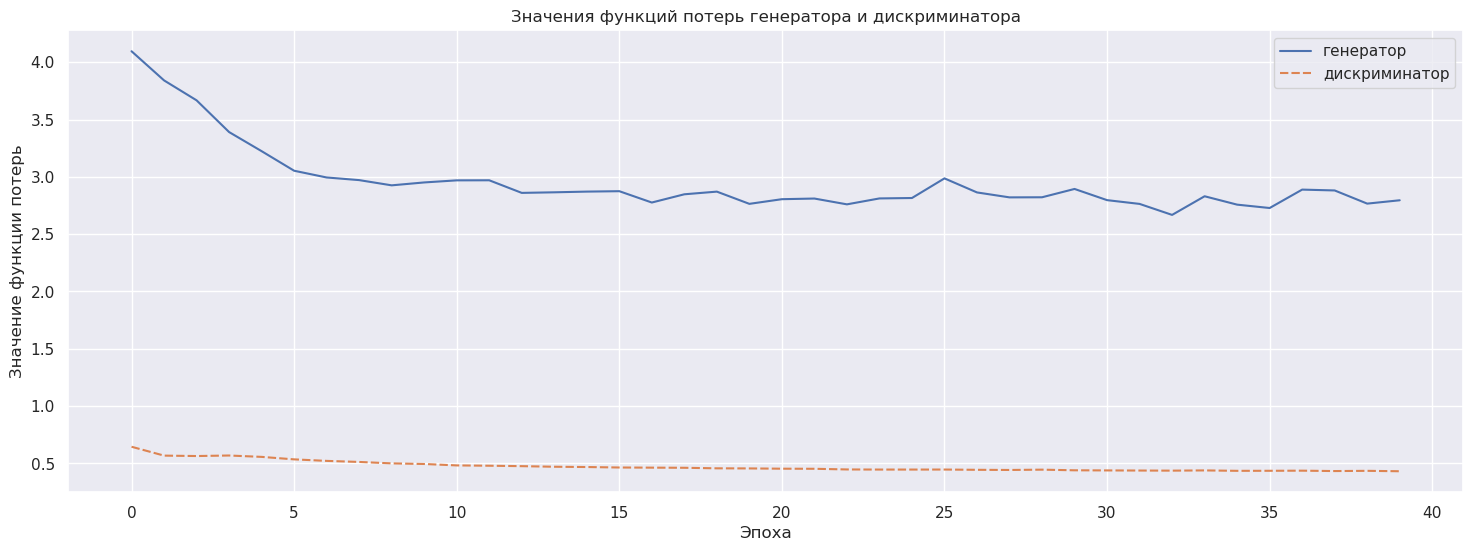

In [ ]:
g = sns.lineplot(data=history[['генератор', 'дискриминатор']])
g.set(title='Значения функций потерь генератора и дискриминатора',
    xlabel='Эпоха',
    ylabel='Значение функции потерь');

Видно, что значения функций потерь генратора и дискриминатора постепенно снижались, а значит наша модель успешно обучалась. 

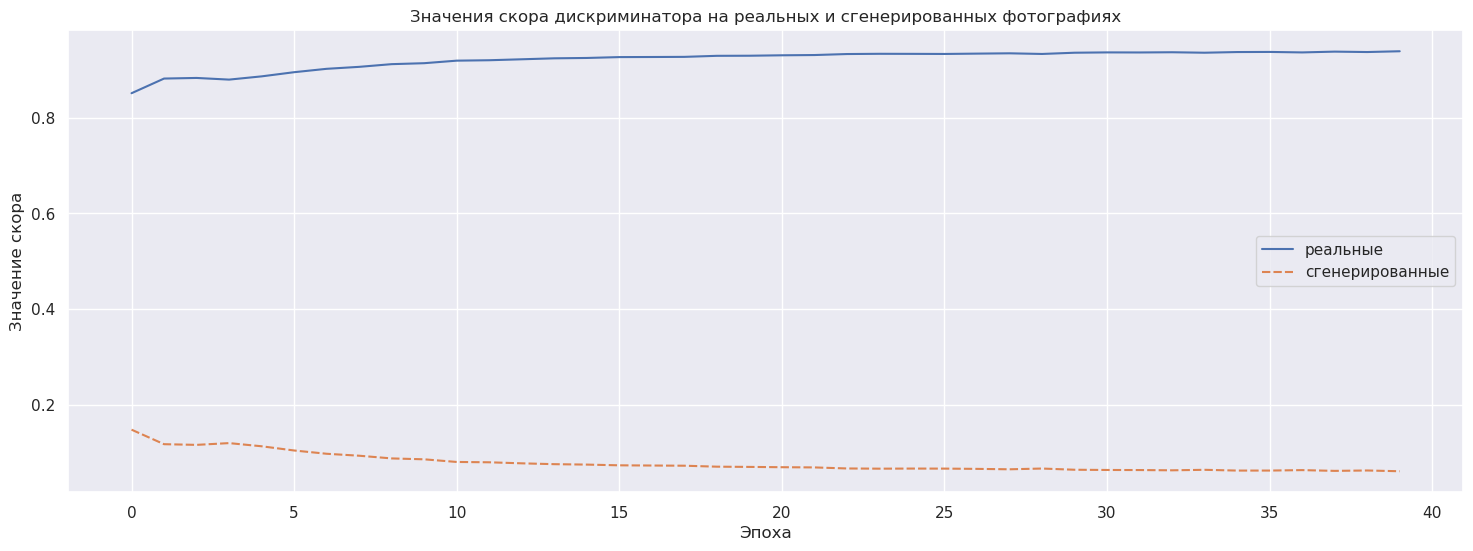

In [ ]:
g = sns.lineplot(data=history[['реальные', 'сгенерированные']])
g.set(title='Значения скора дискриминатора на реальных и сгенерированных фотографиях',
    xlabel='Эпоха',
    ylabel='Значение скора');

Данный график не очень информативен, он показывет, что на протяжении всего времени обучения дискриминатор успешно справлялся со своей задачей и постепенно учился всё лучш распознавать настоящие и сгенерированные изображения, несмотря на все усилия генератора.

Теперь давайте визуально оценим созданные изображения.


Реузльтаты последней эпохи:

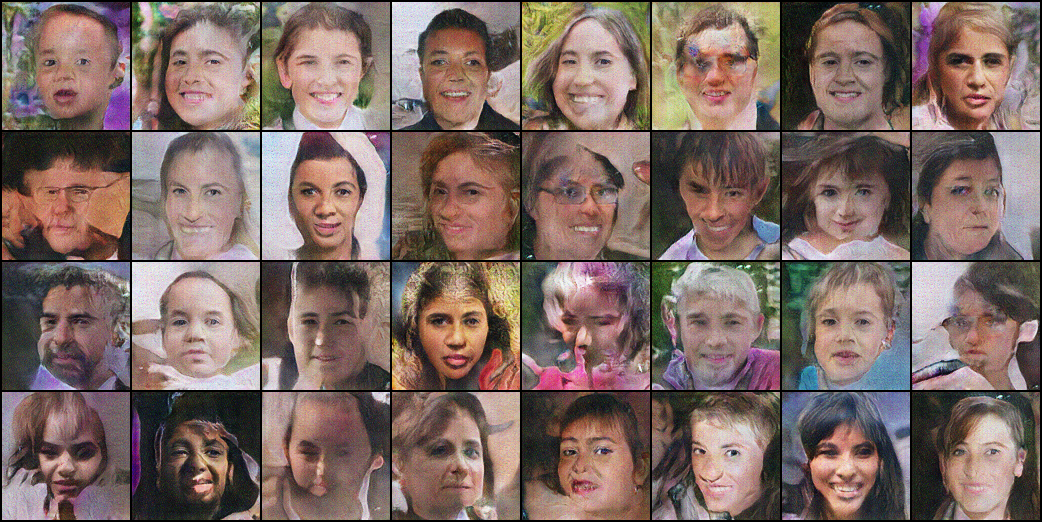

Видно, что фотореалистичности добиться не удалось, что и не удивительно, учитывая простоту нашей модели. Изображения скорее похожи на искажённые фотографии плохого качества. Однако правдоподобность меняется от картинки к картинке: третья слева фотография в первом ряду довольно реалистична, как и вторая справа в том же ряду. Если не вглядываться, то можно спутать с обычной фотографией. Достойный результат для очень простой нейросети!

## Оценки качества генерации

### Применение классификатора

Оценивать качество генерации визуально не всегда удобно. Поэтому реализуем следующую проверку:
* сгенерируем столько же изображений, сколько есть настоящих в обучающей выборке
* сгенерированным изображениям присвоим метку класса 0, настоящим - 1
* посчитаем [`leave-one-out`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html) оценку: обучим классификатор ([`KNeighborsClassifier` при `n=1`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) предсказывать класс на всех объектах, кроме одного, а затем проверим качество (`accuracy`) на оставшемся объекте.

Суть данной проверки довольно проста: если сгенерированные фотографии сильно отличаются от настоящих, то классификатор будет легко различать их и значение метрики `accuracy` будет близко к 1. Если же сгенерированные фотографии очень правдоподобны, то классификатор будет часто ошибаться и значение `accuracy` будет близко к 0.5.

Будем работать с уменьшенной копией нашего датасета, в которой всего 1000 фотографий.

In [ ]:
def prepare_df(image_size=128):
    # реальные фотографии
    os.system('mkdir ./data-small/')
    os.system('unzip -ouq ./thumbnails128x128-small.zip -d ./data-small/')
    
    transforms = tt.Compose([
        tt.Resize(128),
        tt.CenterCrop(128),
        tt.ToTensor(),
        tt.Normalize((0.5, 0.5, 0.5), 
                     (0.5, 0.5, 0.5))
    ])

    train_dataset = ImageFolder(root='./data-small/', 
                                transform=transforms)
    
    train_dataloader = DataLoader(train_dataset, batch_size=1, 
                                  shuffle=True, num_workers=12, 
                                  pin_memory=True)
    # обработаем настоящие фотографии
    real = []

    for X_batch, y_batch in tqdm(train_dataloader):
        X_batch = X_batch.flatten().cpu().numpy()
        real.append(X_batch)
    
    
    real = pd.DataFrame(real)
    real['label'] = 1
    
    # обработаем изображения, созданные генератором
    fake = []
    for _ in trange(len(train_dataloader)):
        fixed_latent = torch.randn(1, LATENT_SIZE, 1, 1, device='cuda')
        fake_images = model.to('cuda')(fixed_latent)
        fake_images = fake_images.flatten().detach().cpu().numpy()
        fake.append(fake_images)
    
    fake = pd.DataFrame(fake)
    fake['label'] = 0

    # sample позволяет перемешать фотографии
    return pd.concat([real, fake], axis=0).sample(frac=1) 

In [ ]:
df = prepare_df()

mkdir: невозможно создать каталог «./data-small/»: Файл существует


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 268 to 263
Columns: 49153 entries, 0 to label
dtypes: float32(49152), int64(1)
memory usage: 375.0 MB


In [ ]:
X = df.drop('label', axis=1)
y = df['label']

In [ ]:
loo = LeaveOneOut()
neigh = KNeighborsClassifier(n_neighbors=1)

In [ ]:
y_true = []
y_pred = []
for train_index, test_index in tqdm(loo.split(df)):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    neigh.fit(X_train, y_train)
    pred = neigh.predict(X_test)

    y_true.append(y_test)
    y_pred.append(pred)

0it [00:00, ?it/s]

In [ ]:
accuracy_score(y_true, y_pred)

0.846

Значение `accuracy` говорит нам о том, что генератор смог обучиться (значение метрики меньше единицы, а значит некоторые сгенерированные изображения довольно близки к реальным), но не идеально (значение метрики больше 0.5, а значит сгенерированные и реальные изображения всё же имеют заметные различия.

### Визуализация распределений

Давайте посмотрим на то, насколько похожи распределения настоящих и сгенерировнных изображений. Для этого воспользуемся методом, снижающим размерность ([`TSNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)) и изобразим на графике разным цветом точки, соответствующие реальным и сгенерированным изображениям.

In [ ]:
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', n_jobs=-1)

In [ ]:
X_tr = tsne.fit_transform(X)

/home/michael/anaconda3/envs/gpu/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [ ]:
X_tr = pd.DataFrame(X_tr)

In [ ]:
X_tr['label'] = y.copy().reset_index(drop=True).map({1: 'настоящее', 0: 'сгенерированное'})

In [ ]:
sns.set(rc={'figure.figsize': (10, 10)})

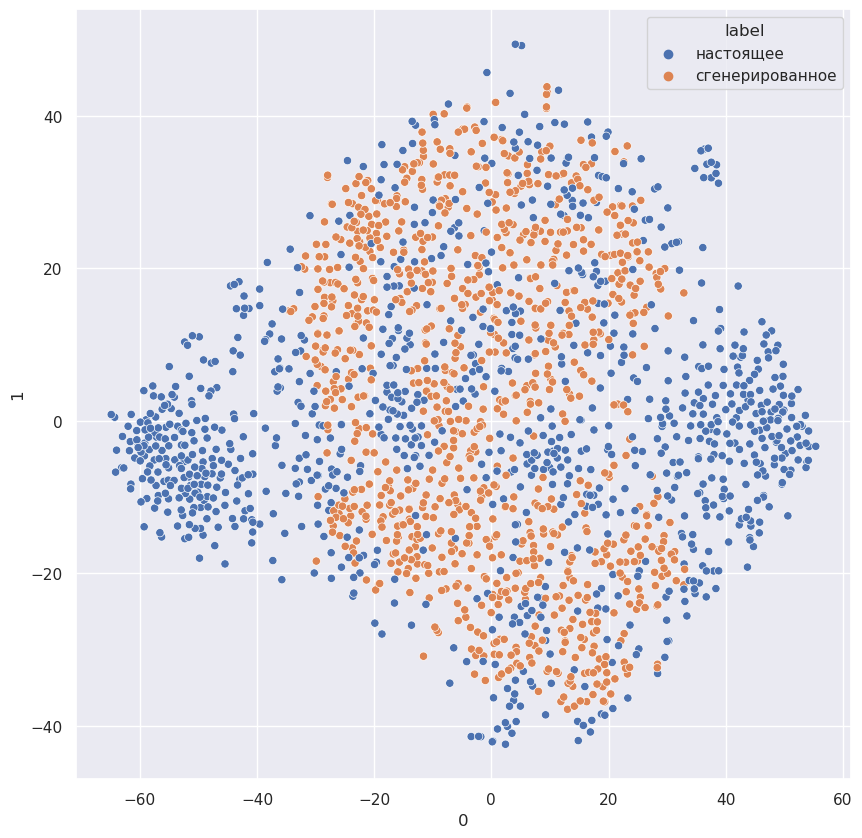

In [ ]:
sns.scatterplot(data=X_tr, x=0, y=1, hue='label');

Видно, что часть точек реальных и сгенерированных изображений визуально разделимы и группируются в разные кластеры. Если бы наш генератор работал хорошо, то такого эффекта бы не было.

## Вывод

В этом проекте мы обучали [генеративно-состязательную нейросеть `(GAN)`](https://ru.wikipedia.org/wiki/%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%BE-%D1%81%D0%BE%D1%81%D1%82%D1%8F%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C) создавать лица людей. В качестве обучающей выборки мы взяли датасет [`Flickr-Faces`](https://github.com/NVlabs/ffhq-dataset).

Генеративно-состязательная сеть состоит из двух отдельных нейросетей: генератора и дискриминатора. Генератор создаёт изображения (в нашем случае - фотографии людей), а дискриминатор пытается отличить их от правильных (настоящих) фотографий. 

Мы создали классы генератора и дискриминатора, а затем объекты этих классов поместили в класс `GAN`. В ходе обучения мы сохраняли значения функций потерь как генератора, так и дискриминатора. 

Для улучшения результатов мы применили несколько трюков: зашумляли изображения, подаваемые на вход дискриминатору, а также, вместо меток классов 0 и 1 использовали метки от 0.0 до 0.1 и от 0.9 до 1.0. Мы делали это для того, чтобы "усложнить жизнь" дискриминатору и дать генератору шанс обучиться.

Результаты генерации на последней эпохе представлены ниже.

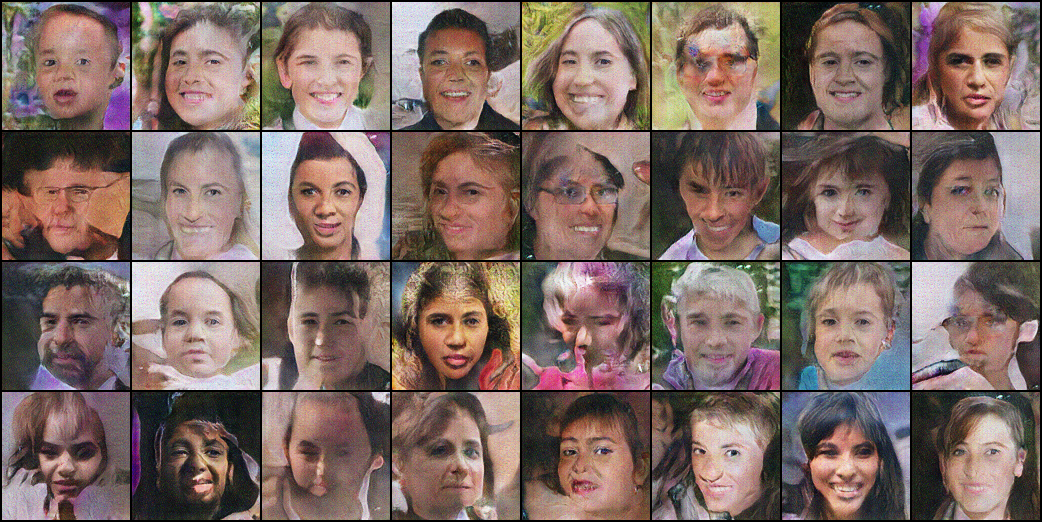

Видно, что фотореалистичности добиться не удалось, что и не удивительно, учитывая простоту нашей модели. Изображения скорее похожи на искажённые фотографии плохого качества. Однако правдоподобность меняется от картинки к картинке: третья слева фотография в первом ряду довольно реалистична, как и вторая справа в том же ряду. Если не вглядываться, то можно спутать с обычной фотографией. Достойный результат для очень простой нейросети!

Так как оценивать качество генерации визуально не всегда удобно, мы реализовали дополнительный критерий оценки следующим образом:
* сгенерировали столько же изображений, сколько есть настоящих в обучающей выборке
* сгенерированным изображениям присвоили метку класса 0, настоящим - 1
* посчитали [`leave-one-out`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html) оценку: обучили классификатор ([`KNeighborsClassifier` при `n=1`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) предсказывать класс на всех объектах, кроме одного, а затем проверили качество (`accuracy`) на оставшемся объекте.

Суть данной проверки довольно проста: если сгенерированные фотографии сильно отличаются от настоящих, то классификатор будет легко различать их и значение метрики `accuracy` будет близко к 1. Если же сгенерированные фотографии очень правдоподобны, то классификатор будет часто ошибаться и значение `accuracy` будет близко к 0.5.

Нам удалось достичь значения метрики 0.846, то есть сгенерированные изображения всё же содержат существенные отличия от реальных, но и не совсем неправдоподобны, что совпрадает с результатами визуального анализа.

Мы также реализовали дополнительную проверку результатов через визуализацию распределений. После снижения размерности изображений методом [`TSNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) мы нанесли получившиеся точки на график. Такая визуализация показала, что часть точек реальных и сгенерированных изображений визуально разделимы и группируются в разные кластеры. Если бы наш генератор работал хорошо, то такого эффекта бы не было.